<a href="https://colab.research.google.com/github/jiw3026/Sentimental_analy/blob/main/01_4_Text_Classification(%EC%BD%94%EB%93%9C%EC%98%88%EC%8B%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy

In [ ]:
import os
import pickle
import json
import re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from konlpy.tag import Okt # komoran, han, kkma

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', header=0, delimiter='\t' ,quoting=3)
test = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', header=0, delimiter='\t' ,quoting=3)

In [ ]:
display(train.head())
display(test.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
train.shape, test.shape

((150000, 3), (50000, 3))

In [ ]:
# config 
NUM_SAMPLES = 50000
TEST_SAMPLES = 10000
EPOCH = 30
IS_DOWNLOAD = True

In [ ]:
def preprocessing(review): 
    okt = Okt()

    stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 토큰화 + 품사 태깅
    word_review = okt.pos(review_text, stem=True)
    
    # 노이즈 & 불용어 제거
    word_review = [(token, pos) for token, pos in word_review if not token in stop_words and len(token) > 1]
    
    # 명사, 동사, 형용사 추출
    word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective']]

    return word_review



In [ ]:
# 전처리 

## 1. 결측치
train.dropna(inplace=True)
test.dropna(inplace=True)

## 2. data 개수 제한  
train = train.iloc[:NUM_SAMPLES]
test = test.iloc[:TEST_SAMPLES]

## 2. train_test_split 
X_train = train.document   
y_train = train.label 

X_test = test.document  
y_test = test.label 

print('#Train set size:', len(X_train))
print('#Test set size:', len(X_test))

## 3. preprocessing
clean_review = []
clean_review_test = []

for review in tqdm(train['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_review.append(preprocessing(review))
    else:
        clean_review.append([])

for review in tqdm(test['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_review_test.append(preprocessing(review))
    else:
        clean_review_test.append([])

print('\nclean_review :', clean_review)
print('\nclean_review_test :', clean_review_test)

#Train set size: 50000
#Test set size: 10000


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# utils 
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train Acc')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Acc')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


### BOW + DENSE

In [ ]:
def dummyTokenizer(x):
    return x

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow = CountVectorizer(tokenizer=dummyTokenizer, preprocessor=dummyTokenizer, min_df=5, max_df=0.5, max_features = 2000) 

# X_train_bow = bow.fit(X_train)
X_train_bow = bow.fit_transform(clean_review)
X_test_bow = bow.transform(clean_review_test)

In [ ]:
print(X_train_bow.shape, X_test_bow.shape)

N_FEATURES = X_train_bow.shape[1]
print("featrue 개수 : ", N_FEATURES)

(50000, 2000) (10000, 2000)
featrue 개수 :  2000


In [ ]:
X_train_bow = X_train_bow.toarray()
X_test_bow = X_test_bow.toarray()

#### 모델링

In [ ]:
model = tf.keras.Sequential([
    Dense(32, input_shape = (N_FEATURES, ), activation = 'relu'),
    Dropout(0.5),
    Dense(16, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64032     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 64,577
Trainable params: 64,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['acc'])

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train_bow, y_train, 
                    validation_split = 0.1, 
                    epochs=EPOCH,
                    callbacks = [earlystopping])
     

Epoch 1/30
1407/1407 [==============================] - 12s 5ms/step - loss: 0.5126 - acc: 0.7458 - val_loss: 0.4207 - val_acc: 0.7990
Epoch 2/30
1407/1407 [==============================] - 5s 4ms/step - loss: 0.4296 - acc: 0.8060 - val_loss: 0.4129 - val_acc: 0.8042
Epoch 3/30
1407/1407 [==============================] - 6s 4ms/step - loss: 0.4091 - acc: 0.8196 - val_loss: 0.4140 - val_acc: 0.8068
Epoch 4/30
1407/1407 [==============================] - 5s 4ms/step - loss: 0.3960 - acc: 0.8264 - val_loss: 0.4147 - val_acc: 0.8080
Epoch 5/30
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3812 - acc: 0.8332 - val_loss: 0.4173 - val_acc: 0.8068


In [ ]:
model.evaluate(X_test_bow, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4211 - acc: 0.8041


[0.4210784137248993, 0.804099977016449]

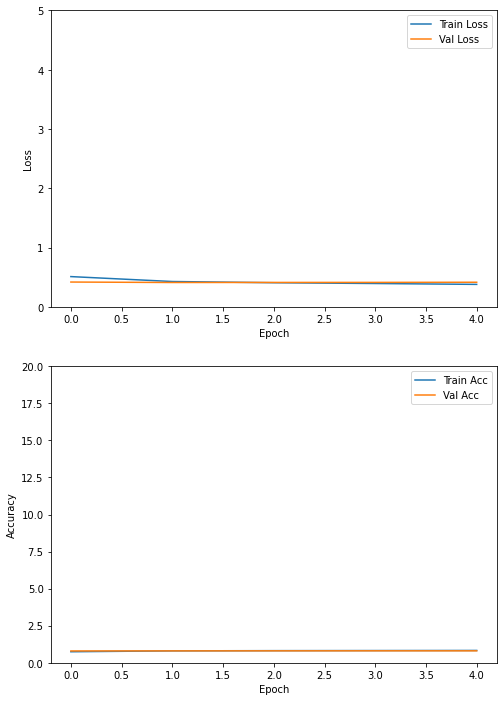

In [ ]:
plot_history(history)

### TF-IDF + DENSE

In [ ]:
tfidf = TfidfVectorizer(tokenizer=dummyTokenizer, preprocessor=dummyTokenizer, max_features=2000, min_df=5, max_df=0.5) 

X_train_tfidf = tfidf.fit_transform(clean_review)
X_test_tfidf = tfidf.transform(clean_review_test)

In [ ]:
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

In [ ]:
print(X_train_tfidf.shape, X_test_tfidf.shape)

N_FEATURES = X_train_tfidf.shape[1]
print("featrue 개수 : ", N_FEATURES)

(50000, 2000) (10000, 2000)
featrue 개수 :  2000


#### 모델링

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                64032     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 64,577
Trainable params: 64,577
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1407/1407 [============================

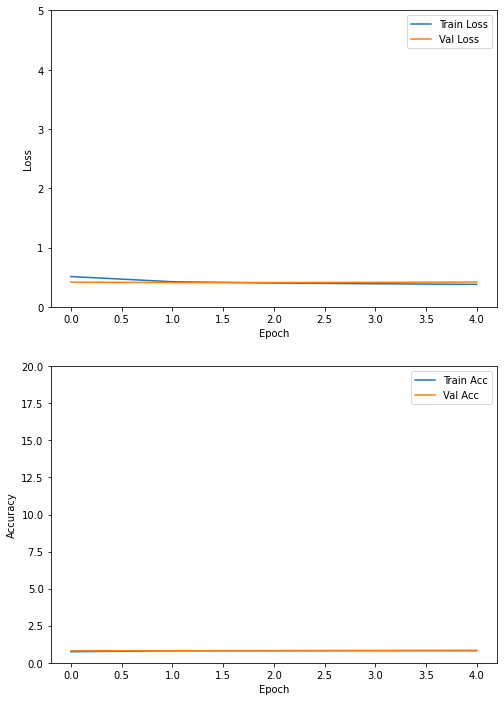

In [ ]:
model = tf.keras.Sequential([
    Dense(32, input_shape = (N_FEATURES, ), activation = 'relu'),
    Dropout(0.5),
    Dense(16, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

model.summary()

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['acc'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train_tfidf, y_train, 
                    validation_split = 0.1, 
                    epochs=EPOCH,
                    callbacks = [earlystopping])

plot_history(history)

In [ ]:
model.evaluate(X_test_tfidf, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4172 - acc: 0.8077


[0.41716092824935913, 0.807699978351593]

## Embedding + Dense

In [ ]:
# data check
print(clean_review[0:3])
print(len(clean_review))
print(len(clean_review_test))

[['더빙', '진짜', '짜증나다', '목소리'], ['포스터', '보고', '초딩', '영화', '오버', '연기', '가볍다', '않다'], ['무재', '밓었', '다그', '래서', '보다', '추천']]
50000
10000


In [ ]:
# 토큰 -> 숫자 
from tensorflow.keras.preprocessing.text import Tokenizer 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_review)

In [ ]:
print(tokenizer.word_index)

{'영화': 1, '하다': 2, '보다': 3, '없다': 4, '있다': 5, '좋다': 6, '정말': 7, '재밌다': 8, '되다': 9, '같다': 10, '진짜': 11, '이다': 12, '않다': 13, '아니다': 14, '만들다': 15, '평점': 16, '연기': 17, '나오다': 18, '최고': 19, '생각': 20, '스토리': 21, '드라마': 22, '감동': 23, '사람': 24, '보고': 25, '이렇다': 26, '아깝다': 27, '감독': 28, '배우': 29, '재미있다': 30, '재미': 31, '시간': 32, '그냥': 33, '내용': 34, '자다': 35, '재미없다': 36, '주다': 37, '지루하다': 38, '쓰레기': 39, '가다': 40, '모르다': 41, '들다': 42, '싶다': 43, '알다': 44, '작품': 45, '사랑': 46, '다시': 47, '마지막': 48, '하나': 49, '그렇다': 50, '이건': 51, '정도': 52, '완전': 53, '오다': 54, '많다': 55, '액션': 56, '장면': 57, '처음': 58, '차다': 59, '주인공': 60, '안되다': 61, '최악': 62, '느낌': 63, '나다': 64, '지금': 65, '별로': 66, '넘다': 67, '역시': 68, '이야기': 69, '연출': 70, '좋아하다': 71, '명작': 72, '남다': 73, '받다': 74, '이영화': 75, '버리다': 76, '이해': 77, '괜찮다': 78, '느끼다': 79, '때문': 80, '해주다': 81, '아름답다': 82, '먹다': 83, '결말': 84, '여자': 85, '보기': 86, '인생': 87, '어떻다': 88, '소재': 89, '보여주다': 90, '기억': 91, '끄다': 92, '어리다': 93, '남자': 94, '아쉽다': 95, '마음': 96, '재다': 97, '낮다

In [ ]:
word_encoding = tokenizer.texts_to_sequences(clean_review)
word_encoding_test = tokenizer.texts_to_sequences(clean_review_test)
print(word_encoding)

[[261, 11, 149, 472], [288, 25, 381, 1, 1083, 17, 487, 13], [1889, 13219, 2134, 3512, 3, 126], [7716, 69, 7717, 128, 31, 4, 16, 3513], [9653, 4507, 17, 493, 1, 1576, 910, 150, 2, 9654, 13220, 136, 150], [4961, 922, 1459, 1364, 6480, 140, 1, 694, 27], [123, 194, 196, 327, 2], [694, 27, 18, 9655, 9656, 1186, 7, 369, 378, 303, 2743, 9657, 1003, 1003, 22, 178, 4, 17, 2, 24], [56, 4, 31, 5, 61, 1], [1024, 16, 98, 1004, 424, 4962, 5], [3514, 11], [473, 695, 104, 218, 2054, 9658, 397, 1577, 476, 2910], [1460, 13221, 9659, 1005, 183, 3076, 17, 612, 2], [2135, 850, 6, 884, 3, 3, 738, 4121, 24, 12], [563, 2475, 6481, 11, 1163, 190, 3, 1, 102, 215, 23, 21, 1421, 23, 1421], [2226, 899, 9, 1719], [59, 24, 107, 6482, 739, 4963, 92, 4508, 739, 1045, 657, 2134, 92, 4964, 150], [4122, 9660, 764, 77, 2, 298, 31, 1058], [51, 7, 1829, 300, 13222, 13, 6483, 6484, 35, 13223, 1829, 2590], [7718, 3515, 392, 675, 244, 14], [209, 1461, 5, 33, 923, 1830, 1214, 1, 244, 14], [3, 181, 13, 2476], [36, 38, 10, 1462, 

In [ ]:
# 문장 길이 맞춰주기 -> padding 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

padded = pad_sequences(word_encoding, padding = 'post')
padded_test = pad_sequences(word_encoding_test, padding = 'post')
print(padded)

[[  261    11   149 ...     0     0     0]
 [  288    25   381 ...     0     0     0]
 [ 1889 13219  2134 ...     0     0     0]
 ...
 [    8     6   119 ...     0     0     0]
 [ 3084   179    23 ...     0     0     0]
 [   31     4   652 ...     0     0     0]]


In [ ]:
VOCAB_SIZE = len(tokenizer.word_index)
print(VOCAB_SIZE)

24450


#### 모델링

embedding vector는 단어벡터를 return -> Dense에는 문장벡터가 들어가야 하므로, 단어벡터를 평균내어 문장벡터를 만들겠습니다. 

In [ ]:
inputs = tf.reshape(tf.range(100), [2, 5, -1]) # 2개의 문장, 5개의 단어, 각 단어는 10개의 차원
inputs

<tf.Tensor: shape=(2, 5, 10), dtype=int32, numpy=
array([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]],

       [[50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]], dtype=int32)>

In [ ]:
GlobalAveragePooling1D()(inputs)

<tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79]], dtype=int32)>

In [ ]:
model = tf.keras.Sequential([
  Embedding(VOCAB_SIZE + 1, 100),
  Dropout(0.1),
  GlobalAveragePooling1D(),
  Dropout(0.1),
  Dense(32, activation = 'relu'),
  Dropout(0.5),
  Dense(16, activation = 'relu'),
  Dense(1, activation = 'sigmoid')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2445100   
                                                                 
 dropout_4 (Dropout)         (None, None, 100)         0         
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                3232      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                      

Epoch 1/30
1407/1407 [==============================] - 33s 22ms/step - loss: 0.5017 - acc: 0.7451 - val_loss: 0.4003 - val_acc: 0.8190
Epoch 2/30
1407/1407 [==============================] - 10s 7ms/step - loss: 0.3661 - acc: 0.8412 - val_loss: 0.4549 - val_acc: 0.7952
Epoch 3/30
1407/1407 [==============================] - 9s 6ms/step - loss: 0.3179 - acc: 0.8646 - val_loss: 0.4360 - val_acc: 0.7990
Epoch 4/30
1407/1407 [==============================] - 9s 7ms/step - loss: 0.2834 - acc: 0.8792 - val_loss: 0.4664 - val_acc: 0.8044


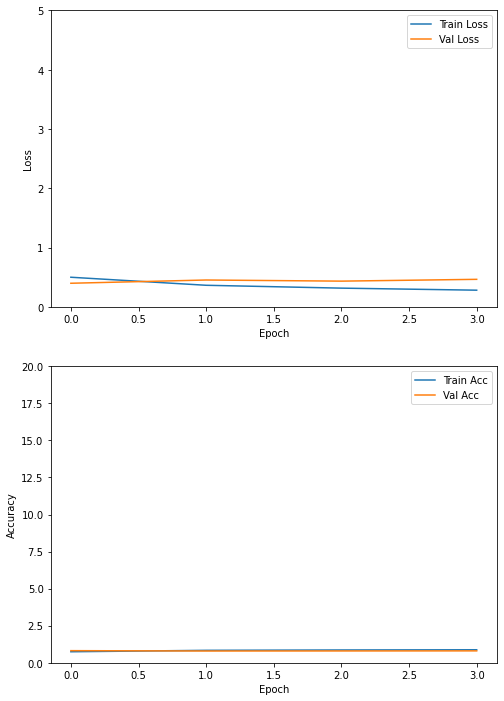

In [ ]:
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['acc'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(padded, y_train, 
                    validation_split = 0.1, 
                    epochs=EPOCH,
                    callbacks = [earlystopping])

plot_history(history)

In [ ]:
model.evaluate(padded_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4931 - acc: 0.8056


[0.49311527609825134, 0.8055999875068665]

## EMBEDDING + RNN

In [ ]:
# data check
print("X padded :", padded)
print("\nX shape :", padded.shape)
print("\ny :", y_train)

X padded : [[  261    11   149 ...     0     0     0]
 [  288    25   381 ...     0     0     0]
 [ 1889 13219  2134 ...     0     0     0]
 ...
 [    8     6   119 ...     0     0     0]
 [ 3084   179    23 ...     0     0     0]
 [   31     4   652 ...     0     0     0]]

X shape : (50000, 47)

y : 0        0
1        1
2        0
3        0
4        1
        ..
49996    0
49997    0
49998    1
49999    1
50000    0
Name: label, Length: 50000, dtype: int64


In [ ]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE+1, 100))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         2445100   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,449,389
Trainable params: 2,449,389
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
1407/1407 [==============================] - 101s 71ms/step - loss: 0.5697 - acc: 0.7015 - val_loss: 0.5199 - val_acc: 0.7542
Epoch 2/30
1407/1407 [==============================] - 74s 52ms/step - loss: 0.4410 - acc: 0.8066 - val_loss: 0.5257 - val_acc: 0.7568
Epoch 3/30
1407/1407 [==============================] - 69s 49ms/step - loss: 0.4005 - acc: 0.8336 - val_loss: 0.5635 - val_acc: 0.7532
Epoch 4/30
1407/1407 [==============================] - 70s 49ms/step - loss: 0.4174 - acc: 0.8153 - val_loss: 0.5363 - val_acc: 0.7612


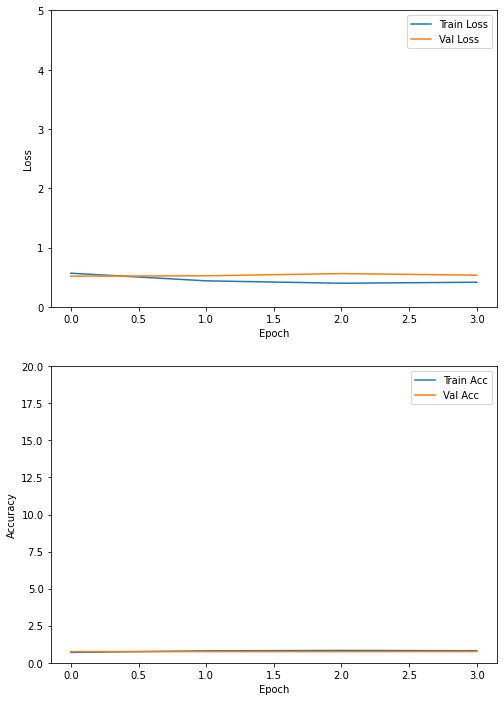

In [ ]:
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['acc'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

history = model.fit(padded, y_train, 
                    validation_split = 0.1, 
                    epochs=EPOCH,
                    callbacks = [earlystopping])

plot_history(history)

In [ ]:
model.evaluate(padded, y_train)

1563/1563 [==============================] - 10s 6ms/step - loss: 0.4428 - acc: 0.8142


[0.4427867829799652, 0.8141800165176392]

In [ ]:
model.evaluate(padded_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.7813 - acc: 0.6139


[0.7812879681587219, 0.6139000058174133]

## LSTM

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         2445100   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,462,157
Trainable params: 2,462,157
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1407/1407 [==============================] - 34s 20ms/step - loss: 0.6122 - acc: 0.6579 - val_loss: 0.6012 - val_acc: 0.6710
Epoch 2/30
1407/1407 [==============================] - 12s 8ms/step - loss: 0.5639 - acc: 0.7401 - val_loss: 0.5856 - val_acc: 0.7272
Epoch 3/30
1407/1407 [==========

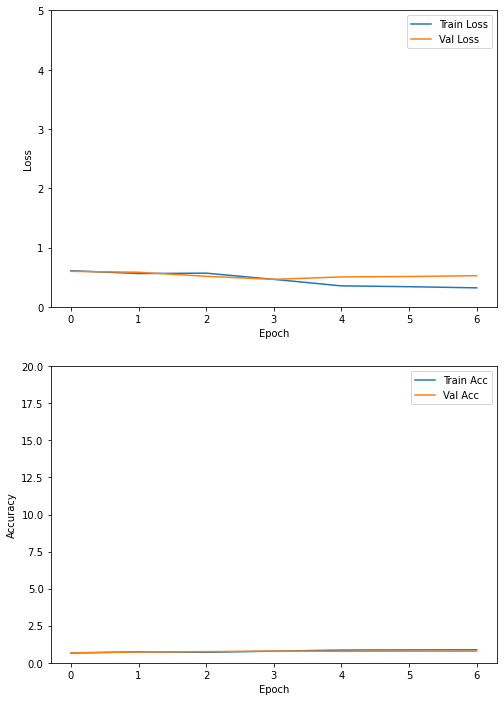

In [ ]:
from tensorflow.keras.layers import LSTM
model = Sequential()

model.add(Embedding(VOCAB_SIZE+1, 100))
model.add(LSTM(32))
model.add(Dense(1, activation = 'sigmoid'))

print(model.summary())

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['acc'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

history = model.fit(padded, y_train, 
                    validation_split = 0.1, 
                    epochs=EPOCH,
                    callbacks = [earlystopping])

plot_history(history)

In [ ]:
model.evaluate(padded_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.4675 - acc: 0.7894


[0.46752262115478516, 0.7893999814987183]

## Inference

In [ ]:
import re 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from konlpy.tag import Okt 

okt = Okt()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_review) # 단어 인덱스 구축

max_len = len(padded[0])

def sentiment_predict(new_sentence):
  new_sentence = preprocessing(new_sentence)
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 영화 핵노잼ㅋㅋ')

1/1 [==============================] - 0s 349ms/step
60.02% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('또 보고 싶다')

1/1 [==============================] - 0s 20ms/step
63.55% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('돈 아까움')

1/1 [==============================] - 0s 18ms/step
58.40% 확률로 부정 리뷰입니다.

